In [1]:
import torch
import os
import shutil
from Loader import TrainLoader
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from Network import Net
import torch.nn as nn
import cv2
import torchvision.utils as utils
import torchvision

In [2]:
# dataset at https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
main_dir = "D:\\Workshops\\CNN_workshop\\workshop"

In [3]:
def data_split(main_dir, train_ratio, val_ratio, test_ratio):
    yes_dir = os.path.join(main_dir, "archive", "yes")
    no_dir = os.path.join(main_dir, "archive", "no")
    yes_names = os.listdir(yes_dir)
    no_names = os.listdir(no_dir)
    len_yes = len(yes_names)
    len_no = len(no_names)
    
    yes_train_names = yes_names[:int(train_ratio*len_yes)]
    no_train_names = no_names[:int(train_ratio*len_no)]
    
    yes_val_names = yes_names[int(train_ratio*len_yes):int((train_ratio+val_ratio)*len_yes)]
    no_val_names = no_names[int(train_ratio*len_no):int((train_ratio+val_ratio)*len_no)]
    
    yes_test_names = yes_names[int((train_ratio+val_ratio)*len_yes):]
    no_test_names = no_names[int((train_ratio+val_ratio)*len_no):]
    
    # creating data folder
    data_dir = os.path.join(main_dir, "data")
    train_dir = os.path.join(data_dir, 'train')
    val_dir = os.path.join(data_dir, 'val')
    test_dir = os.path.join(data_dir, 'test')
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
        os.mkdir(train_dir)
        os.mkdir(val_dir)
        os.mkdir(test_dir)
        
    # copying train data
    for yes_train_sample in yes_train_names:
        source = os.path.join(yes_dir, yes_train_sample)
        destination = os.path.join(train_dir, yes_train_sample)
        shutil.copy(source, destination)
    for no_train_sample in no_train_names:
        source = os.path.join(no_dir, no_train_sample)
        destination = os.path.join(train_dir, no_train_sample)
        shutil.copy(source, destination)  
        
    for yes_val_sample in yes_val_names:
        source = os.path.join(yes_dir, yes_val_sample)
        destination = os.path.join(val_dir, yes_val_sample)
        shutil.copy(source, destination)
    for no_val_sample in no_val_names:
        source = os.path.join(no_dir, no_val_sample)
        destination = os.path.join(val_dir, no_val_sample)
        shutil.copy(source, destination) 
        
    for yes_test_sample in yes_test_names:
        source = os.path.join(yes_dir, yes_test_sample)
        destination = os.path.join(test_dir, yes_test_sample)
        shutil.copy(source, destination)
    for no_test_sample in no_test_names:
        source = os.path.join(no_dir, no_test_sample)
        destination = os.path.join(test_dir, no_test_sample)
        shutil.copy(source, destination)  
    
    
    return yes_names, no_names

In [4]:
y, n = data_split(main_dir, 0.6, 0.2, 0.2)

In [5]:
batch_size = 32

In [6]:
train_path = "D:\\Workshops\\CNN_workshop\\workshop\\data\\train"
val_path = "D:\\Workshops\\CNN_workshop\\workshop\\data\\val"
test_path = "D:\\Workshops\\CNN_workshop\\workshop\\data\\test"
train_loader_obj = TrainLoader(train_path, y, n)
train_loader = DataLoader(dataset=train_loader_obj, batch_size = batch_size, shuffle=True)
val_loader_obj = TrainLoader(val_path, y, n)
val_loader = DataLoader(val_loader_obj, batch_size = batch_size, shuffle = True)
test_loader_obj = TrainLoader(test_path, y, n)
test_loader = DataLoader(test_loader_obj, batch_size = batch_size, shuffle = True)

In [7]:
iterator = iter(val_loader)
images, labels = next(iterator)

In [8]:
images.shape

torch.Size([32, 320, 320, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


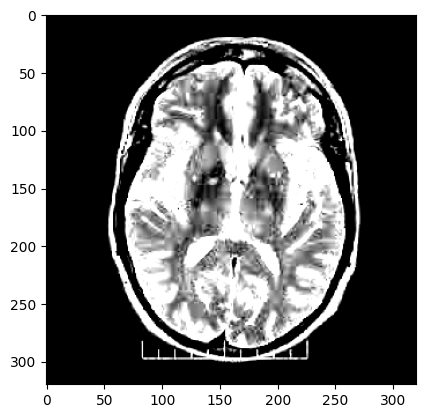

In [9]:
plt.imshow(images[0])

# Creating Network

In [10]:
net = Net()
device = "cuda"
net = net.to(device)

In [11]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

31282


In [12]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Train the neural network
epoch_acc = 0
iterator = iter(val_loader)
images_val, labels_val = next(iterator)
for epoch in range(500):
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device).float()
        inputs = inputs.permute(0, 3, 1, 2)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    net.eval()

    inputs = images_val.to(device).float()
    inputs = inputs.permute(0, 3, 1, 2)
    with torch.no_grad():
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1) 
    
    diff = predicted.to(device) - labels_val.to(device)
    acc = 1- sum(abs(diff))/len(predicted)
    print("Accuracy of epoch {} is {}".format(epoch+1, acc*100))
    
    if acc > epoch_acc:
        weight_name = "Conv_weights.pt"
        torch.save(net.state_dict(), weight_name)
        epoch_acc = acc

print('Finished Training')

Accuracy of epoch 1 is 37.5
Accuracy of epoch 2 is 37.5
Accuracy of epoch 3 is 37.5
Accuracy of epoch 4 is 62.5
Accuracy of epoch 5 is 62.5
Accuracy of epoch 6 is 62.5
Accuracy of epoch 7 is 62.5
Accuracy of epoch 8 is 62.5
Accuracy of epoch 9 is 62.5
Accuracy of epoch 10 is 62.5
Accuracy of epoch 11 is 62.5
Accuracy of epoch 12 is 62.5
Accuracy of epoch 13 is 62.5
Accuracy of epoch 14 is 62.5
Accuracy of epoch 15 is 62.5
Accuracy of epoch 16 is 62.5
Accuracy of epoch 17 is 62.5
Accuracy of epoch 18 is 62.5
Accuracy of epoch 19 is 62.5
Accuracy of epoch 20 is 62.5
Accuracy of epoch 21 is 62.5
Accuracy of epoch 22 is 62.5
Accuracy of epoch 23 is 62.5
Accuracy of epoch 24 is 62.5
Accuracy of epoch 25 is 62.5
Accuracy of epoch 26 is 62.5
Accuracy of epoch 27 is 62.5
Accuracy of epoch 28 is 62.5
Accuracy of epoch 29 is 62.5
Accuracy of epoch 30 is 62.5
Accuracy of epoch 31 is 62.5
Accuracy of epoch 32 is 62.5
Accuracy of epoch 33 is 62.5
Accuracy of epoch 34 is 62.5
Accuracy of epoch 35 is

Accuracy of epoch 278 is 62.5
Accuracy of epoch 279 is 62.5
Accuracy of epoch 280 is 62.5
Accuracy of epoch 281 is 62.5
Accuracy of epoch 282 is 62.5
Accuracy of epoch 283 is 62.5
Accuracy of epoch 284 is 62.5
Accuracy of epoch 285 is 62.5
Accuracy of epoch 286 is 62.5
Accuracy of epoch 287 is 62.5
Accuracy of epoch 288 is 62.5
Accuracy of epoch 289 is 62.5
Accuracy of epoch 290 is 62.5
Accuracy of epoch 291 is 62.5
Accuracy of epoch 292 is 62.5
Accuracy of epoch 293 is 62.5
Accuracy of epoch 294 is 62.5
Accuracy of epoch 295 is 62.5
Accuracy of epoch 296 is 62.5
Accuracy of epoch 297 is 62.5
Accuracy of epoch 298 is 62.5
Accuracy of epoch 299 is 62.5
Accuracy of epoch 300 is 62.5
Accuracy of epoch 301 is 62.5
Accuracy of epoch 302 is 62.5
Accuracy of epoch 303 is 62.5
Accuracy of epoch 304 is 62.5
Accuracy of epoch 305 is 62.5
Accuracy of epoch 306 is 62.5
Accuracy of epoch 307 is 62.5
Accuracy of epoch 308 is 62.5
Accuracy of epoch 309 is 62.5
Accuracy of epoch 310 is 62.5
Accuracy o

In [13]:
#weight_name = "Conv_weights.pt"
#torch.save(net.state_dict(), weight_name)
net.load_state_dict(torch.load("Conv_weights.pt"))

<All keys matched successfully>

In [15]:
net

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
iterator = iter(test_loader)
images, labels = next(iterator)

In [14]:
with torch.no_grad():
    net.eval()
    inputs = images.to(device).float()
    inputs = inputs.permute(0, 3, 1, 2)
    with torch.no_grad():
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

    print(labels)
    print(predicted)

tensor([1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1])
tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 1, 1, 1, 0, 1], device='cuda:0')


In [15]:
diff = predicted.to(device) - labels.to(device)
acc = 1- sum(abs(diff))/len(predicted)
print(acc)

tensor(0.7500, device='cuda:0')


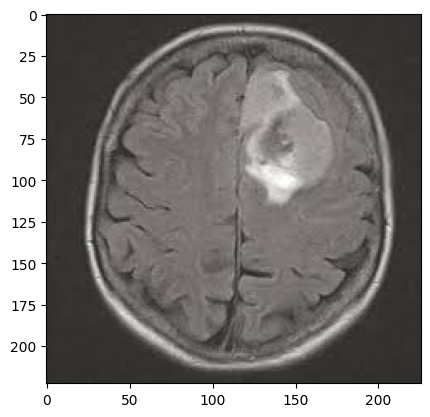

In [18]:
input_image = cv2.imread("D:\\Workshops\\CNN_workshop\\workshop\\data\\test\\Y82.jpg")
plt.imshow(input_image)
input_image = input_image/255.0
input_image = (input_image - np.mean(input_image))/np.std(input_image)
input_image = torch.from_numpy(input_image)
input_image = input_image.unsqueeze(0).float().to(device)
input_image = input_image.permute(0, 3, 1, 2)
conv3_output = net.conv3(net.pool(nn.functional.relu(net.conv2(net.pool(nn.functional.relu(net.conv1(input_image))))))).detach()
conv3_output = conv3_output.squeeze()
conv3_output = conv3_output.detach().to('cpu')
conv3_output = np.array(conv3_output)

In [19]:
conv1_output = net.conv1(input_image).detach()
conv1_output = conv1_output.squeeze()
conv1_output = conv1_output.detach().to('cpu')
conv1_output = np.array(conv1_output)

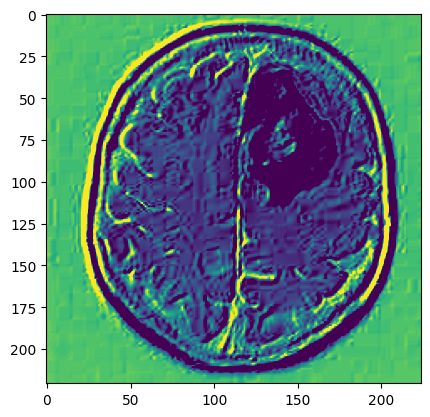

In [22]:
plt.imshow(conv1_output[12], vmin=0, vmax=1)
plt.show()

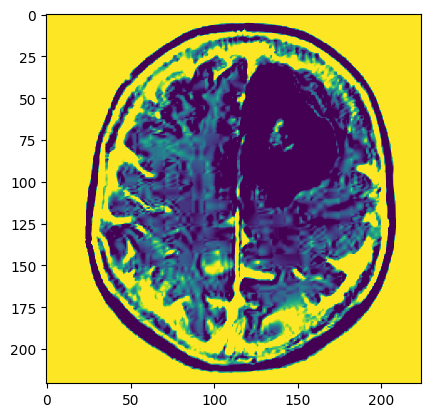

In [23]:
plt.imshow(conv1_output[5], vmin=0, vmax=1)
plt.show()

# Transfer Learning

In [16]:
from ReNet_model import ResNet

In [17]:
net = ResNet()
device = "cuda"
net = net.to(device)

D:\Workshops\CNN_workshop\workshop\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Workshops\CNN_workshop\workshop\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

23778690


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the neural network
epoch_acc = 0
iterator = iter(val_loader)
images_val, labels_val = next(iterator)
for epoch in range(500):
    for i, data in enumerate(train_loader, 0):
        # Get the inputs and labels
        inputs, labels = data
        labels = labels.to(device)
        inputs = inputs.to(device).float()
        inputs = inputs.permute(0, 3, 1, 2)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
    net.eval()

    inputs = images_val.to(device).float()
    inputs = inputs.permute(0, 3, 1, 2)
    with torch.no_grad():
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1) 
    
    diff = predicted.to(device) - labels_val.to(device)
    acc = 1- sum(abs(diff))/len(predicted)
    print("Accuracy of epoch {} is {}".format(epoch+1, acc*100))
    
    if acc > epoch_acc:
        weight_name = "best_model.pt"
        torch.save(net.state_dict(), weight_name)
        epoch_acc = acc
    
print('Finished Training')

Accuracy of epoch 1 is 59.375
Accuracy of epoch 2 is 59.375
Accuracy of epoch 3 is 59.375
Accuracy of epoch 4 is 59.375
Accuracy of epoch 5 is 59.375
Accuracy of epoch 6 is 59.375
Accuracy of epoch 7 is 59.375
Accuracy of epoch 8 is 59.375
Accuracy of epoch 9 is 71.875
Accuracy of epoch 10 is 81.25
Accuracy of epoch 11 is 84.375
Accuracy of epoch 12 is 81.25
Accuracy of epoch 13 is 90.625
Accuracy of epoch 14 is 84.375
Accuracy of epoch 15 is 53.125
Accuracy of epoch 16 is 62.5
Accuracy of epoch 17 is 96.875
Accuracy of epoch 18 is 84.375
Accuracy of epoch 19 is 87.5
Accuracy of epoch 20 is 81.25
Accuracy of epoch 21 is 81.25
Accuracy of epoch 22 is 65.625
Accuracy of epoch 23 is 84.375
Accuracy of epoch 24 is 90.625
Accuracy of epoch 25 is 87.5
Accuracy of epoch 26 is 87.5
Accuracy of epoch 27 is 84.375
Accuracy of epoch 28 is 87.5
Accuracy of epoch 29 is 87.5
Accuracy of epoch 30 is 87.5
Accuracy of epoch 31 is 84.375
Accuracy of epoch 32 is 81.25
Accuracy of epoch 33 is 84.375
Accur

KeyboardInterrupt: 

In [32]:
net.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [40]:
iterator = iter(test_loader)
images, labels = next(iterator)

In [45]:
with torch.no_grad():
    net.eval()
    inputs = images.to(device).float()
    inputs = inputs.permute(0, 3, 1, 2)
    with torch.no_grad():
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

    print(labels)
    print(predicted)
    
    diff = predicted.to(device) - labels.to(device)
    acc = 1- sum(abs(diff))/len(predicted)
    print(acc)

tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1])
tensor([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
tensor(0.8438, device='cuda:0')


In [47]:
input_image = cv2.imread("D:\\Workshops\\CNN_workshop\\workshop\\data\\test\\Y82.jpg")
input_image = input_image/255.0
input_image = (input_image - np.mean(input_image))/np.std(input_image)
input_image = torch.from_numpy(input_image)
input_image = input_image.unsqueeze(0).float().to(device)
input_image = input_image.permute(0, 3, 1, 2)

In [48]:
conv1_output = net.resnet[:4][0](input_image).detach()
conv1_output = conv1_output.squeeze()
conv1_output = conv1_output.detach().to('cpu')
conv1_output = np.array(conv1_output)

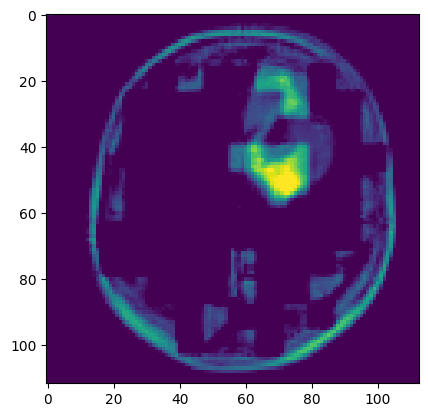

In [49]:
plt.imshow(conv1_output[1], vmin=0, vmax=1)
plt.show()

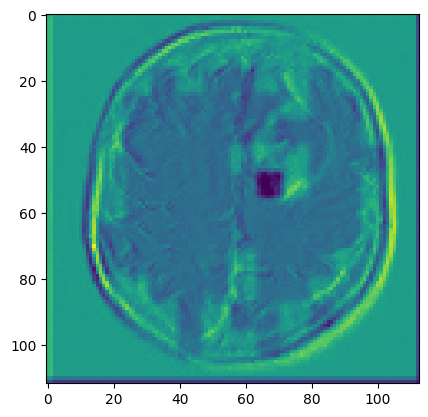

In [50]:
plt.imshow(conv1_output[19], vmin=0, vmax=1)
plt.show()

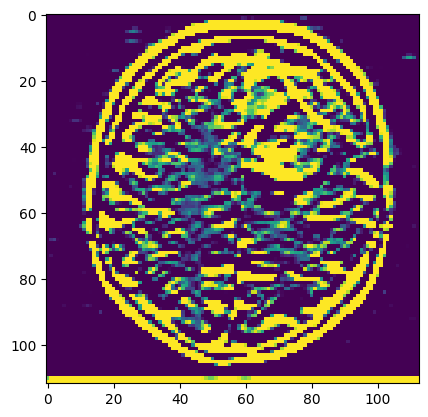

In [68]:
plt.imshow(conv1_output[3], vmin=0, vmax=1)
plt.show()

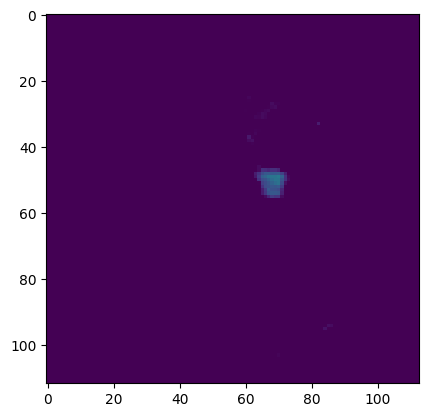

In [71]:
plt.imshow(conv1_output[29], vmin=0, vmax=1)
plt.show()